### clustering by SPI offset percentages (L, W)

>> **PartType**: 0402: width 200 um, length 400 um | 0603: width 300 um, length 600 um | 1005: width 500 um, length 1000 um

>> **CRD**: B: 0402, C: 0603, D: 1005

In [3]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import warnings
warnings.filterwarnings("ignore")

import time
from sklearn.cluster import KMeans
import matplotlib.cm as cm

np.random.seed(42)

dir_path = pathlib.Path().absolute()
file = '../../data/imputed_data.csv'
data_path = os.path.join(dir_path, file)
print('MOM4 data path:', data_path)

df = pd.read_csv(data_path, index_col=False).drop(['Unnamed: 0'], axis=1)
df.reset_index(drop=True, inplace=True)
assert df.isnull().sum().sum() == 0

print('total (after imputation):',len(df))
df.head()

MOM4 data path: /home/user/Documents/ky-bayesopt/data_analysis/notebooks/../../data/imputed_data.csv
total (after imputation): 182250


,CRD,PartType,Orient.,X,Y,SPI_VOLUME1,SPI_VOLUME2,SPI_L,SPI_W,SqueegeeCd,...,POST_L,POST_W,Job,Chip_L,Chip_W,SPI_R,PRE_R,POST_R,SPI_VOLUME_MEAN,SPI_VOLUME_DIFF
0,B1,R0402,90.0,31.26,100.11,81.7355,75.6950,61.90,52.0,R1,...,28.108231,7.440417,CENTER,400.0,200.0,80.843120,19.972320,29.076321,78.71525,6.0405
1,B2,R0402,90.0,31.83,100.11,83.1555,71.5083,63.70,47.0,R1,...,22.242701,-5.487133,CENTER,400.0,200.0,79.162428,27.640847,22.909526,77.33190,11.6472
2,B3,R0402,90.0,32.40,100.11,87.0870,67.2606,72.35,41.6,R1,...,12.971593,19.644203,CENTER,400.0,200.0,83.457070,33.071929,23.540538,77.17380,19.8264
3,B4,R0402,90.0,32.97,100.11,80.0433,75.8866,63.10,50.6,R1,...,26.396389,22.517658,CENTER,400.0,200.0,80.882446,24.242596,34.696027,77.96495,4.1567
4,B5,R0402,90.0,33.54,100.11,76.7088,74.0452,69.45,50.0,R1,...,29.193306,21.413681,CENTER,400.0,200.0,85.576296,8.781555,36.204901,75.37700,2.6636


100%|██████████| 486/486 [00:48<00:00,  9.92it/s]


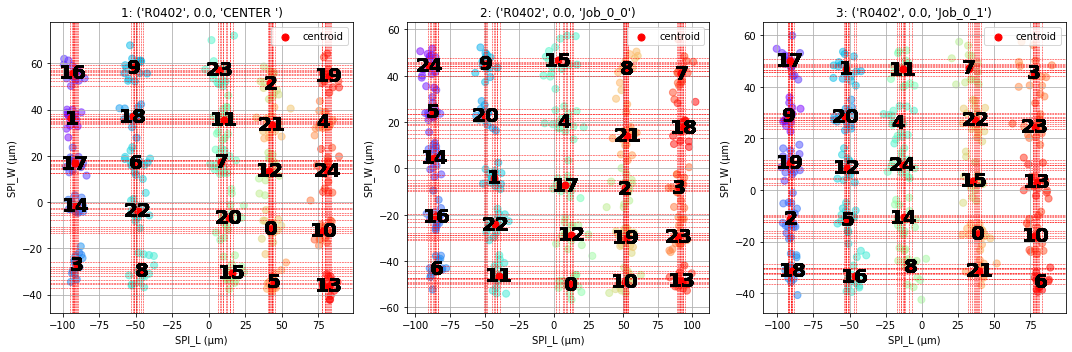

In [7]:
''' 
data: 3*2*(9*9)*15*(5*5) = 182250

	for each of 3 chips
		for each of 2 orientations
			for each of (9*9) chip placement offset conditions (jobs)
				for each of (5*5) spi conditions
					repeat for 15 reps

clustering method
	0. preparation: group by chip, orientation, job
	1. spi l, spi w --> KMeans clusters
	2. find cluster centers and sort each (spi l, spi w) into respective percentage
	3. associate spi l and spi w at each cluster center with the corresponding row index in df
	4. for that index, insert at that index spi percentage in a list 
	5. insert the final filled list into df
'''


dfgroups = df.groupby(['PartType','Orient.', 'Job'])
num_figs_to_visualize = 3 # total: dfgroups.ngroups (= 3*2*81 = 486)
fig = plt.figure(figsize=(num_figs_to_visualize*5, 5))
plot_subplot_idx = 1

num_repetitions = 15
group_stats = dict()
visualize = True
spiws = []
spils = []

t = tqdm(enumerate(dfgroups), total=len(dfgroups))
for group_idx, (name, group) in t:
    for row_idx, row in group.iterrows():
        # exception case: 'CENTER '
        if row['Job'] == 'CENTER ': row['Job'] = 'CENTER'

	# each group has 375 (=25*15) rows
    assert len(group) == 375
    clf = KMeans(n_clusters=25).fit(group[['SPI_L','SPI_W']]) 
    centroids = clf.cluster_centers_
    labels = clf.labels_
    # labels = KMeans(n_clusters=25).fit_predict(group[['SPI_L','SPI_W']]) # worse center estimation results
    assert len(labels) == 375
    group['labels'] = labels.astype(int)
    group['cluster_spi_w'] = centroids[labels, 1]
    group['cluster_spi_l'] = centroids[labels, 0]
    
    # assign centroids to percentages
    # group.sort_values(by='labels', inplace=True)    # sort group by labels
    group_stats[group_idx] = len(set(group['labels']))  # check how many labels into each cluster
    
    # sort by cluster l, w
    group.sort_values(by=['cluster_spi_l'], ascending=[True], inplace=True)
    x = list(group['labels'])
    ordered_labels_by_l = sorted(x, key=x.index)
    assert len(ordered_labels_by_l) == 25*15

    spi_l_percentage = np.zeros(len(group))
    spi_w_percentage = np.zeros(len(group))
    idx_to_percentage = {0: -20, 1: -10, 2: 0, 3: 10, 4: 20}

    for wi, block in enumerate(np.array_split(ordered_labels_by_l, 5)): # 5 blocks
        block = list(block)
        filtered = group[group['labels'].isin(block)]                               # extract rows with labels corresponding to each block
        filtered.sort_values(by=['cluster_spi_w'], ascending=False, inplace=True)   # retrieve labels whose spi w values are in order

        spi_w_percentage[wi*(num_repetitions*5):((wi+1)*num_repetitions*5)] = np.repeat(idx_to_percentage[wi], num_repetitions*5)         # spi_w_percentage, length: 15*5 = 75 for each block
        spi_l_percentage[wi*num_repetitions*5:((wi+1)*num_repetitions*5)] = np.repeat(list(idx_to_percentage.values()), num_repetitions)  # spi_l_percentage

    group['spi_w_percentage'] = spi_w_percentage # length: 375
    group['spi_l_percentage'] = spi_l_percentage # length: 375

    spiws.extend(spi_w_percentage)
    spils.extend(spi_l_percentage)
    df.iloc[group.index, :] = group # temp update

    # visualize for verification
    if visualize:
        if plot_subplot_idx == num_figs_to_visualize+1:
            continue

        ax = fig.add_subplot(1, num_figs_to_visualize, plot_subplot_idx)
        colors = cm.rainbow(np.linspace(0, 1, len(labels)))
        ax.scatter(group['SPI_L'], group['SPI_W'], c=colors, s=50, alpha=0.5, label='_nolegend_')
        ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50, label='centroid')
        # annotate label
        for i, label in enumerate(group['labels']):
            ax.annotate(label, (centroids[label,0], centroids[label,1]),
                    horizontalalignment='center',
                    verticalalignment='center',
                    size=20, weight='bold', color='black') # backgroundcolor='white', color=colors[i])

        # draw bounding lines for centroidss
        for ctrd in centroids:
            ax.axhline(y=ctrd[1]-1, color='r', linestyle='--', linewidth=0.5)
            ax.axhline(y=ctrd[1]+1, color='r', linestyle='--', linewidth=0.5)

            ax.axvline(x=ctrd[0]-1, color='r', linestyle='--', linewidth=0.5)
            ax.axvline(x=ctrd[0]+1, color='r', linestyle='--', linewidth=0.5)

        ax.set_xlabel(f'SPI_L (\u03BCm)')
        ax.set_ylabel(f'SPI_W (\u03BCm)')
        ax.legend(loc='upper right')
        ax.grid()
        ax.set_title(f'{group_idx+1}: {name}')
        
        plot_subplot_idx += 1

try:
    df.insert(5, 'spi_w_percentage', np.array(spiws).astype(int))
    df.insert(5, 'spi_l_percentage', np.array(spils).astype(int))
except:
    df['spi_w_percentage'] = np.array(spiws).astype(int)
    df['spi_l_percentage'] = np.array(spils).astype(int)

# print(group_stats)
fig.tight_layout()
plt.savefig('spi_lw.png', facecolor='w', bbox_inches='tight')
plt.show()


In [8]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)
df.to_csv('spi_clustered.csv')
df.head(30)

,CRD,PartType,Orient.,X,Y,spi_l_percentage,spi_w_percentage,SPI_VOLUME1,SPI_VOLUME2,SPI_L,SPI_W,SqueegeeCd,PRE_X,PRE_Y,PRE_A,PRE_L,PRE_W,POST_X,POST_Y,POST_A,POST_L,POST_W,Job,Chip_L,Chip_W,SPI_R,PRE_R,POST_R,SPI_VOLUME_MEAN,SPI_VOLUME_DIFF
0,B1,R0402,90.0,31.26,100.11,-20,-20,81.7355,75.6950,61.90,52.00,R1,-19.887293,-1.840963,-1.877,-1.840963,19.887293,-7.440417,28.108231,1.613,28.108231,7.440417,CENTER,400.0,200.0,80.843120,19.972320,29.076321,78.71525,6.0405
1,B2,R0402,90.0,31.83,100.11,-20,-20,83.1555,71.5083,63.70,47.00,R1,-26.766272,6.898049,-1.449,6.898049,26.766272,5.487133,22.242701,0.000,22.242701,-5.487133,CENTER,400.0,200.0,79.162428,27.640847,22.909526,77.33190,11.6472
2,B3,R0402,90.0,32.40,100.11,-20,-20,87.0870,67.2606,72.35,41.60,R1,-32.058273,8.125244,-3.278,8.125244,32.058273,-19.644203,12.971593,1.552,12.971593,19.644203,CENTER,400.0,200.0,83.457070,33.071929,23.540538,77.17380,19.8264
3,B4,R0402,90.0,32.97,100.11,-20,-20,80.0433,75.8866,63.10,50.60,R1,-23.437572,-6.195457,-3.337,-6.195457,23.437572,-22.517658,26.396389,0.000,26.396389,22.517658,CENTER,400.0,200.0,80.882446,24.242596,34.696027,77.96495,4.1567
4,B5,R0402,90.0,33.54,100.11,-20,-20,76.7088,74.0452,69.45,50.00,R1,-5.187286,7.085744,-3.408,7.085744,5.187286,-21.413681,29.193306,3.611,29.193306,21.413681,CENTER,400.0,200.0,85.576296,8.781555,36.204901,75.37700,2.6636
5,B6,R0402,90.0,31.26,99.20,-20,-20,87.5890,67.7356,59.75,49.10,R1,-31.059980,1.531298,3.611,1.531298,31.059980,-5.925862,17.682121,0.000,17.682121,5.925862,CENTER,400.0,200.0,77.336101,31.097705,18.648679,77.66230,19.8534
6,B7,R0402,90.0,31.83,99.20,-20,-20,82.3075,72.8240,60.10,44.95,R1,-20.728939,10.258562,-3.247,10.258562,20.728939,-17.024027,33.615910,3.455,33.615910,17.024027,CENTER,400.0,200.0,75.050067,23.128489,37.680856,77.56575,9.4835
7,B8,R0402,90.0,32.40,99.20,-20,-20,85.6800,72.5218,70.00,39.05,R1,-27.195978,11.357373,-2.031,11.357373,27.195978,-1.401807,29.627155,3.337,29.627155,1.401807,CENTER,400.0,200.0,80.155490,29.472210,29.660300,79.10090,13.1582
8,B9,R0402,90.0,32.97,99.20,-20,-20,87.2831,76.6458,62.45,46.55,R1,-19.822590,1.057152,-3.047,1.057152,19.822590,-20.989681,15.195607,3.310,15.195607,20.989681,CENTER,400.0,200.0,77.890340,19.850759,25.912800,81.96445,10.6373
9,B10,R0402,90.0,33.54,99.20,-20,-20,84.4009,74.3327,71.15,53.25,R1,-26.842043,3.604794,-3.022,3.604794,26.842043,-17.169552,31.046926,-1.660,31.046926,17.169552,CENTER,400.0,200.0,88.870046,27.083017,35.478235,79.36680,10.0682


In [5]:
# from collections import defaultdict
# from sklearn.cluster import KMeans

# def list_duplicates(seq):
# 	tally = defaultdict(list)
# 	for i, item in enumerate(seq):
# 		tally[item].append(i)
# 	return ((key, locs) for key, locs in tally.items() if len(locs) > 1)

# missing_sample = dict()
# fig = plt.figure(figsize=(18, 5), facecolor='white')
# temp_dfs = df.copy()